# Letters

## Description

This project was developed as part of the Computer Vision and Image Processing course within the Master's in Software Engineering at the University of Minho.

The objective of this project is to generate an image that highlights the edges of letters present in a noisy image.


## Group 3

Francisco Afonso - PG57873

Jéssica Cunha - A100901

Martim Redondo - PG57889

In [ ]:
import cv2
import matplotlib.pyplot as plt 
import numpy as np

Image shape: (400, 600)
(400, 600)


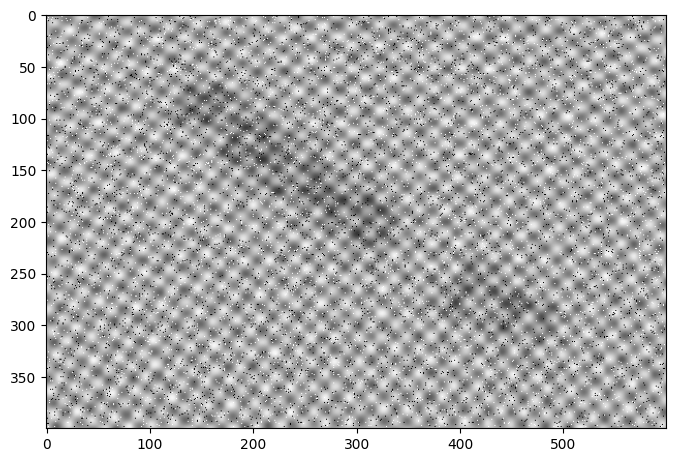

In [2]:
fname = 'Letters-noisy.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
H, W = img.shape
# Print the image shape
print(f"Image shape: {img.shape}")
print(img.shape)
ratio=W/H
fig = plt.figure(figsize=(8,8*ratio))
plt.imshow(img, cmap='gray')

# First analyses

Upon analysing the image, a distinct chessboard pattern is evident, along with noise distributed throughout the entire image.

The presence of the chessboard pattern suggests the application of a notch filter, while the noise can be effectively addressed using an Ideal Low-Pass Filter (ILPF).

To validate this approach, the first step is to generate a magnitude spectrum of the image.

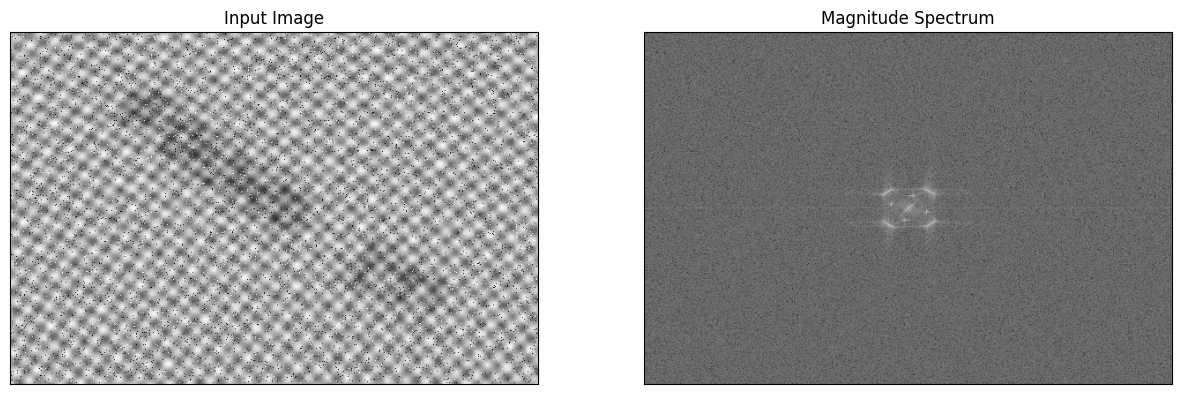

In [3]:
img_float32 = np.float32(img)

# compute the DFT
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)


# display the image and the spectrum
fig = plt.figure(figsize=(15,5))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

**The spectrum confirmed the previous analyses.**

The diagonal lines and the four star shaped dots indicates the color variation provocated by the chessboard patter.

The noise along the entire spectrum indicates the dot noise on the image.

## First filter - Notch filter

Considering the analyses the first filter being applied is the notch filter.

In [4]:
# shape: (W,H) are the width and height of the filter

# d0 is the radius of the filter expressed in pixels

# u_k and v_k are the center coordinates in the Fourier image plane for the notch filter
# u_k=0, v_k=0 correspond to the center of the shifted spectrum

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

In [ ]:
# fill in the following lists to compose multiple notch filters
d0_list = [10, 10] + [7, 8]
u_k_list = [18, 18] + [ 0, 18]
v_k_list = [25, -23] + [ 18, -2]

H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)

    H *= Haux

# apply mask and inverse DFT
dft_masked = dft_shift*H
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_notch = cv2.idft(dft_masked_ishift)

# img_notch should only have real values
# but let's make sure due to rounding and representation errors
img_notch = cv2.magnitude(img_notch[:,:,0],img_notch[:,:,1])
# normalize to ensure that the values are in the range [0,1]
cv2.normalize(img_notch, img_notch, 0, 1, cv2.NORM_MINMAX)

In [6]:
# compute the DFT
dft = cv2.dft(img_notch, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude
filtered_spectrum = 20*np.log(filtered_spectrum+0.0001)

In [7]:
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

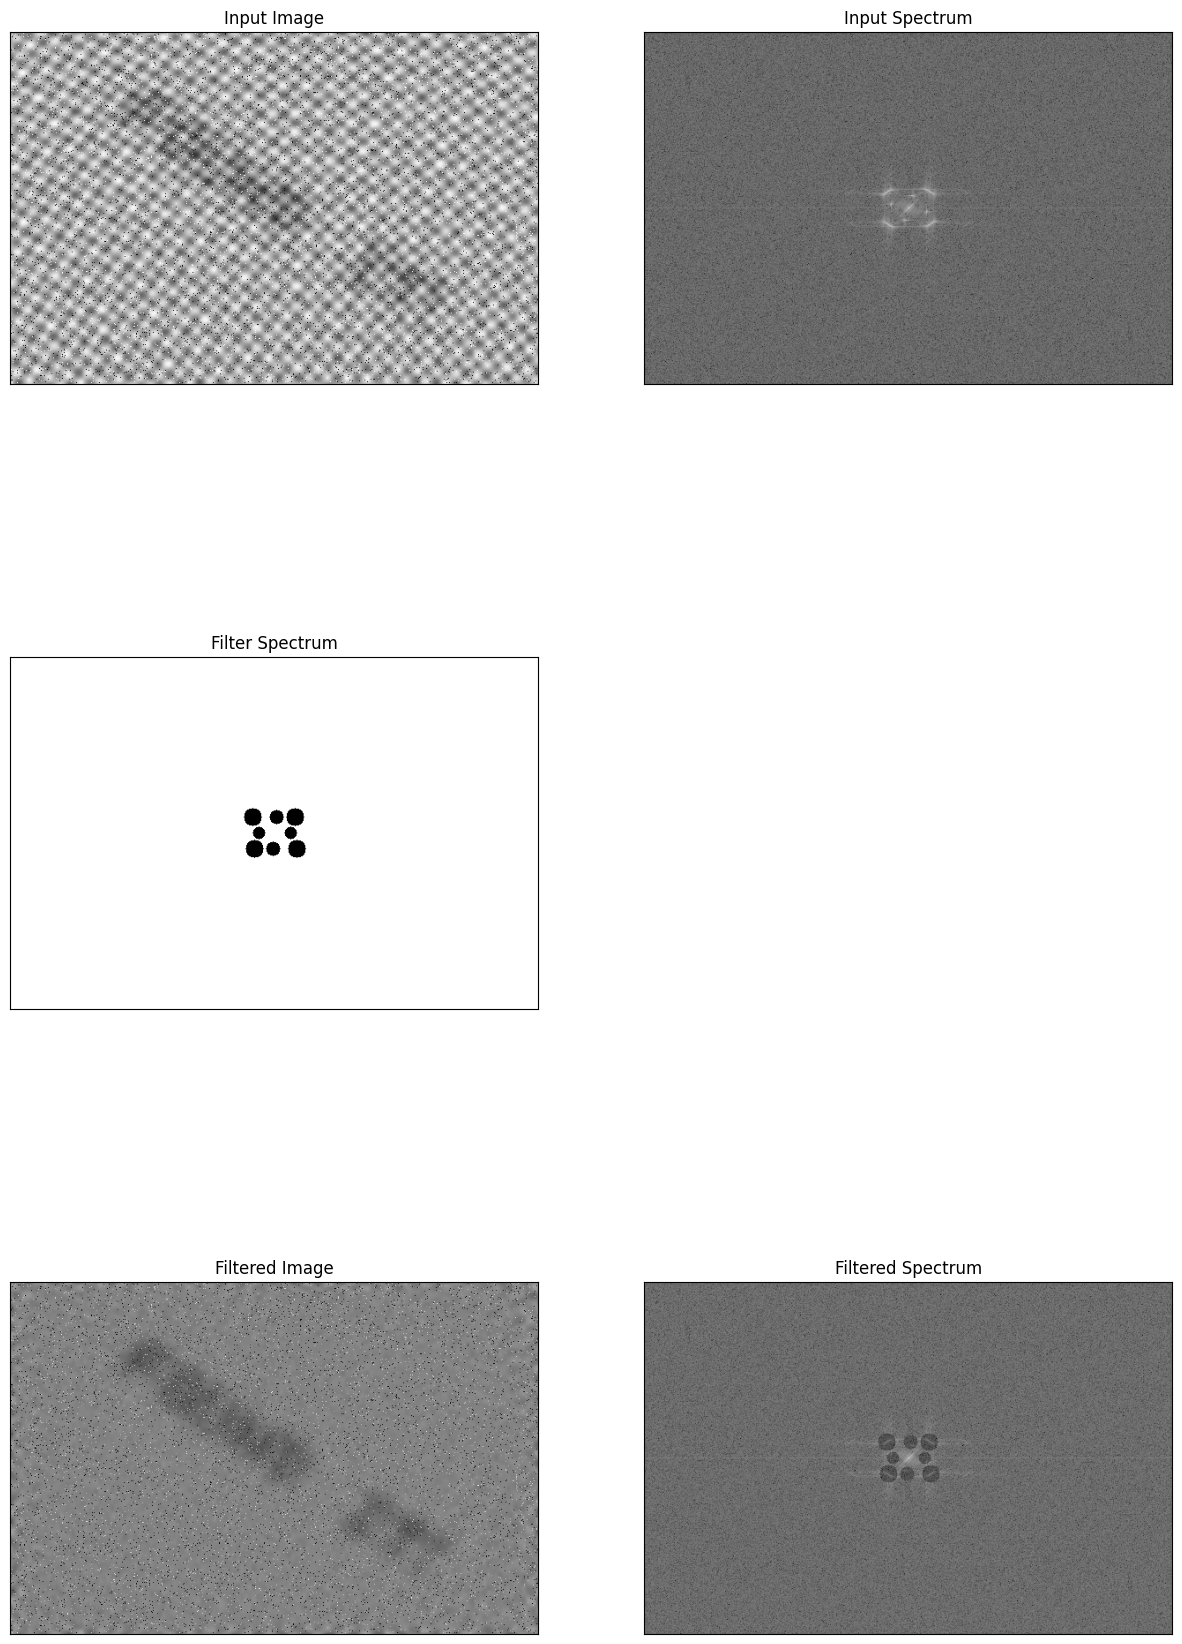

In [8]:
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_notch, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

### Notch filter results

The notch filter considerally reduced the chessboard pattern.

Now, the next step is to apply an ILPF to remove the noise.


In [9]:
# manually filter high frequencies using our own ILPF
rows, cols = img_notch.shape
crow, ccol = rows//2 , cols//2     # center

# create a mask first, center square is 1, remaining all zeros
ILPF_mask = np.zeros((rows, cols, 2), np.uint8)
# filter width and heigth
divider = 16
frows = rows//divider
fcols = cols//divider
ILPF_mask[crow-frows:crow+frows, ccol-fcols:ccol+fcols] = (1,1)

# apply mask and inverse DFT
dft_masked = dft_proc_shift*ILPF_mask
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [10]:
# compute the frequency spectrum of the MASKED_DFT, 
# just for display purposes
# module of the complex value

dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift = np.fft.fftshift(dft_proc)
filtered_spectrum_ilpf = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
filtered_spectrum_ilpf = 20*np.log(filtered_spectrum_ilpf+0.0001)
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(ILPF_mask[:,:,0],2)+np.power(ILPF_mask[:,:,1],2))
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

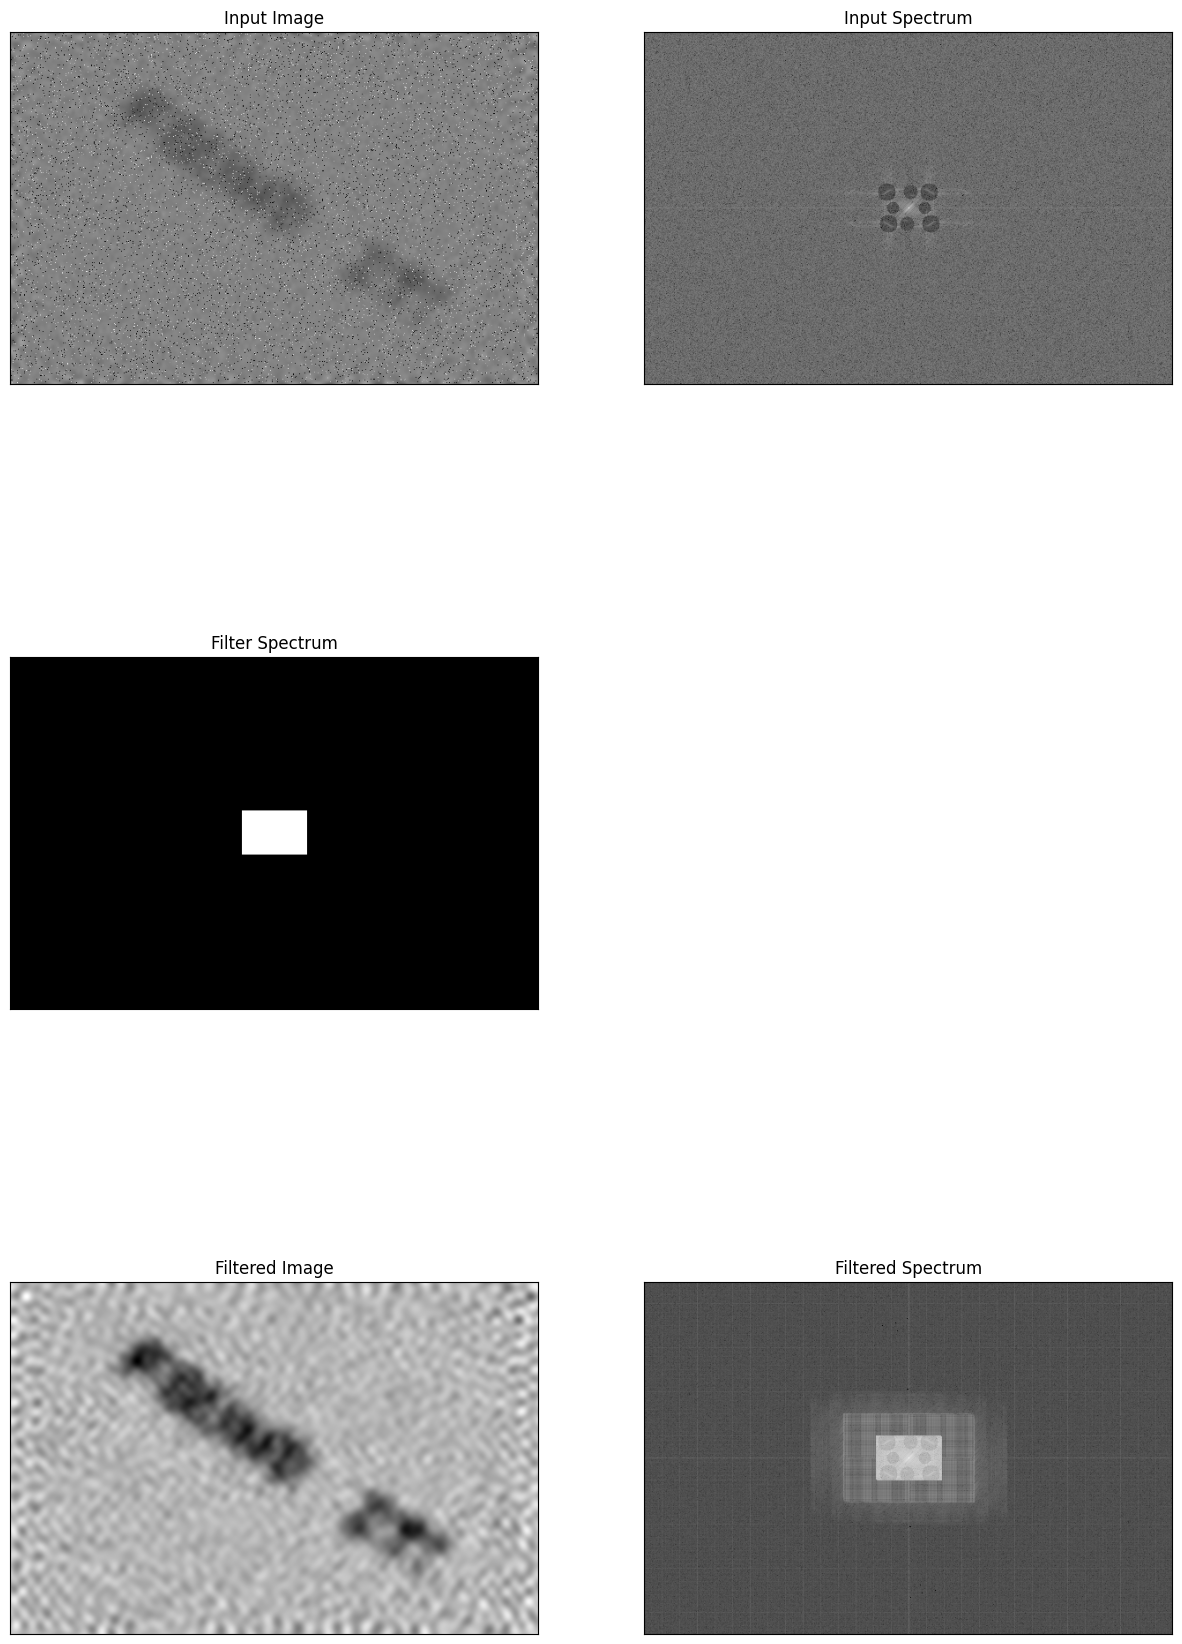

In [11]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img_notch, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum_ilpf, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

Upon applying the ILPF, an unexpected behavior was observed, characterized by the appearance of banding and the loss of information in the frequency spectrum.

This issue may be caused by the computation of the Discrete Fourier Transform (DFT), as the DFT assumes periodicity, effectively treating the image as if it repeats across its boundaries. This assumption can lead to discontinuities at the edges, resulting in artifacts such as banding.

A potential solution to mitigate this problem is to expand the image by adding borders and effectively doubling its size. This technique helps reduce the visible effects of periodicity at the image boundaries, thus minimizing banding and preserving more information in the spectrum.

To analyze the optimal solution for the borders, three approaches were tested: white borders, black borders, and mirrored borders.

In [12]:
def rescale (image):
    image = np.absolute(image)
    mymin=np.amin(image)
    mymax=np.amax(image)
    W = image.shape[0]
    H = image.shape[1]
    #for y in range(H): 
    #    for x in range(W): 
    #        image[x,y] = (image[x,y]-mymin)*255/(mymax-mymin)
    scale = 255/(mymax-mymin)
    image = (image-mymin)* scale
    image = np.ndarray.astype(image, dtype=np.uint8, copy=True)
    return image

Original Image Shape: (400, 600)
Resized Image Shape: (565, 848)


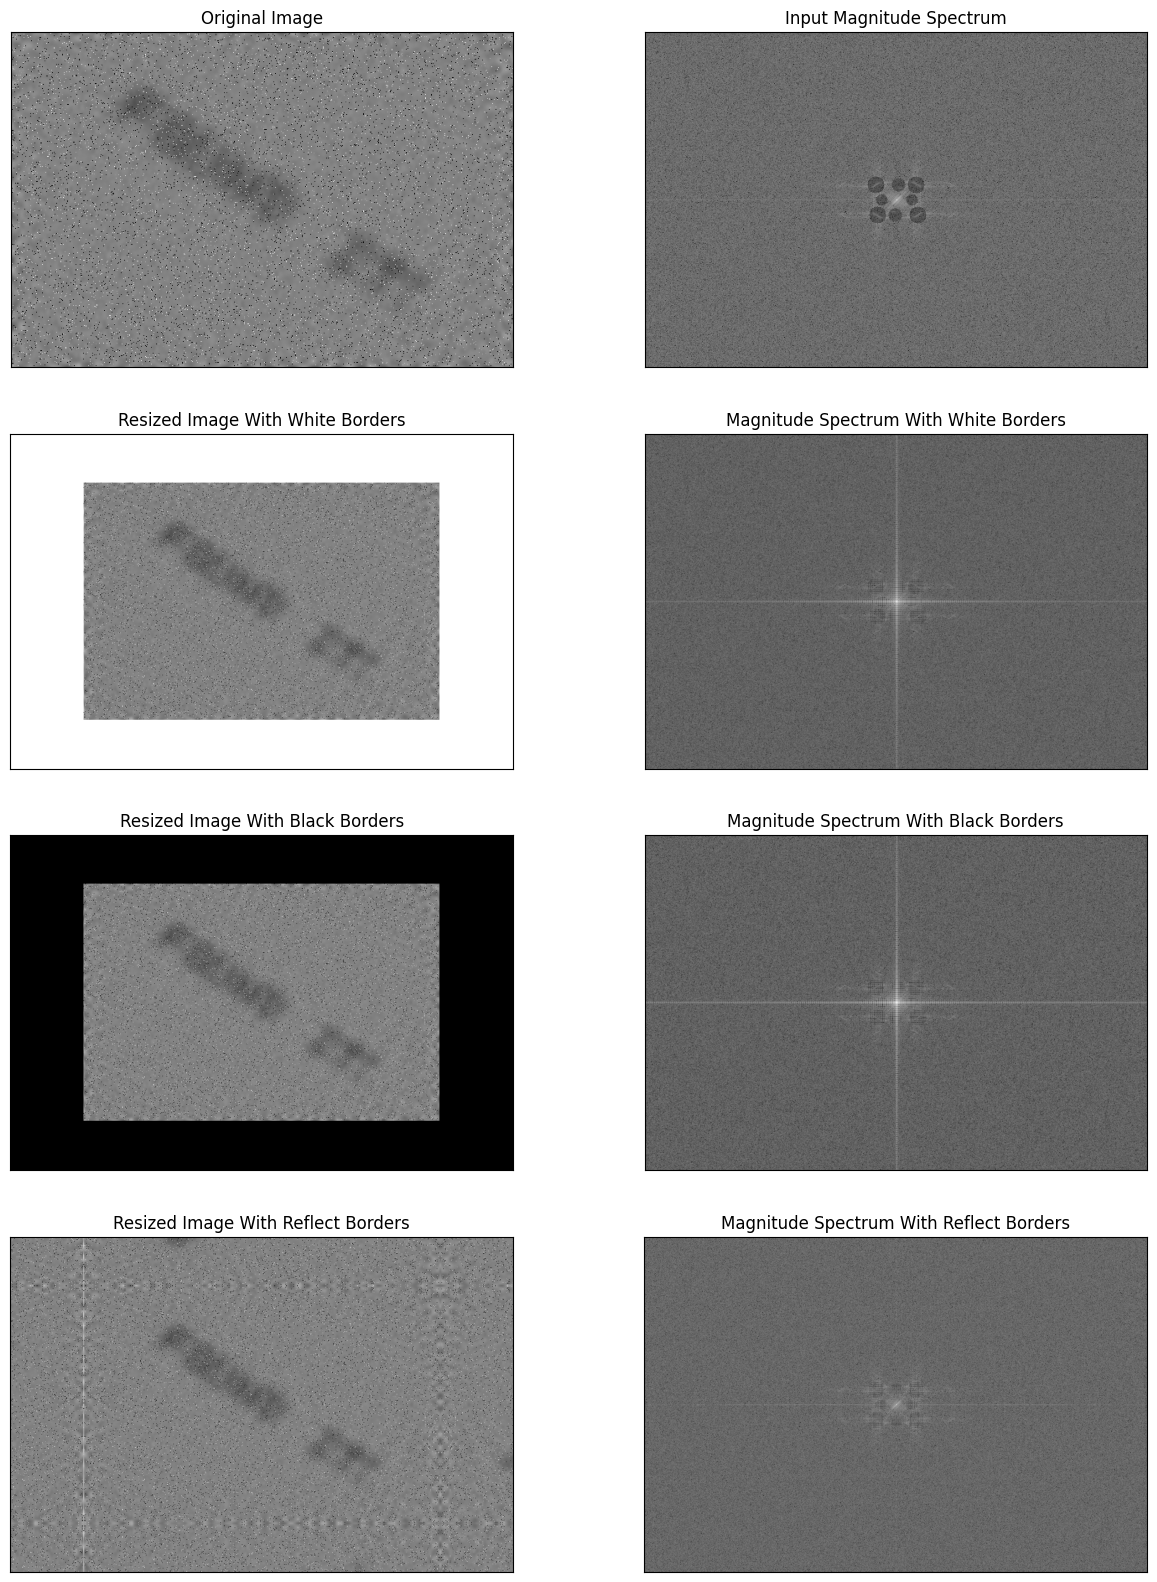

In [13]:
rescaled_img = rescale(img_notch)

# Compute new dimensions to double the area (not just the dimensions)
new_image_height = int(rows * np.sqrt(2))
new_image_width = int(cols * np.sqrt(2))

# Initialize the resized image with black padding (for grayscale)
resized_img_white = np.full((new_image_height, new_image_width), 255, dtype=np.uint8)
resized_img_black = np.full((new_image_height, new_image_width), 0, dtype=np.uint8)

# Compute the center offsets for pasting the original image into the resized image
x_center = (new_image_width - cols) // 2
y_center = (new_image_height - rows) // 2

# Ensure the center offsets are non-negative
x_center = max(x_center, 0)
y_center = max(y_center, 0)

# Create a resized image with mirrored padding
resized_img_reflect = cv2.copyMakeBorder(rescaled_img, y_center, y_center, x_center, x_center, cv2.BORDER_REFLECT)

# Copy the original image into the center of the resized image
resized_img_white[y_center:y_center + rows, x_center:x_center + cols] = rescaled_img
resized_img_black[y_center:y_center + rows, x_center:x_center + cols] = rescaled_img

# Convert the resized image to float32 for DFT
img_float32_resized_w = np.float32(resized_img_white)
img_float32_resized_b = np.float32(resized_img_black)
img_float32_reflect = np.float32(resized_img_reflect)

# Compute the DFT (Discrete Fourier Transform)
dft = cv2.dft(img_notch, flags=cv2.DFT_COMPLEX_OUTPUT)

# Recenter the DFT such that the center is (0, 0)
dft_shift = np.fft.fftshift(dft)

# Compute the frequency spectrum (magnitude spectrum)
magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])

# Apply logarithmic scale to make smaller values visible
magnitude_spectrum = 20 * np.log(magnitude_spectrum)

# WHITE BORDERS
dft_resized_w = cv2.dft(img_float32_resized_w, flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift_resized_w = np.fft.fftshift(dft_resized_w)
magnitude_spectrum_resized_w = cv2.magnitude(dft_shift_resized_w[:, :, 0], dft_shift_resized_w[:, :, 1])
magnitude_spectrum_resized_w = 20 * np.log(magnitude_spectrum_resized_w)

# BLACK BORDERS
dft_resized_b = cv2.dft(img_float32_resized_b, flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift_resized_b = np.fft.fftshift(dft_resized_b)
magnitude_spectrum_resized_b = cv2.magnitude(dft_shift_resized_b[:, :, 0], dft_shift_resized_b[:, :, 1])
magnitude_spectrum_resized_b = 20 * np.log(magnitude_spectrum_resized_b)

# REFLECT BORDERS
dft_reflect = cv2.dft(img_float32_reflect, flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift_reflect = np.fft.fftshift(dft_reflect)
magnitude_spectrum_reflect = cv2.magnitude(dft_shift_reflect[:, :, 0], dft_shift_reflect[:, :, 1])
magnitude_spectrum_reflect = 20 * np.log(magnitude_spectrum_reflect + 1)


print("Original Image Shape:", img_notch.shape)
print("Resized Image Shape:", resized_img_white.shape)

fig = plt.figure(figsize=(15, 20))

plt.subplot(421), plt.imshow(img_notch, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(422), plt.imshow(filtered_spectrum, cmap='gray')
plt.title('Input Magnitude Spectrum'), plt.xticks([]), plt.yticks([])

plt.subplot(423), plt.imshow(resized_img_white, cmap='gray')
plt.title('Resized Image With White Borders'), plt.xticks([]), plt.yticks([])

plt.subplot(424), plt.imshow(magnitude_spectrum_resized_w, cmap='gray')
plt.title('Magnitude Spectrum With White Borders'), plt.xticks([]), plt.yticks([])

plt.subplot(425), plt.imshow(resized_img_black, cmap='gray')
plt.title('Resized Image With Black Borders'), plt.xticks([]), plt.yticks([])

plt.subplot(426), plt.imshow(magnitude_spectrum_resized_b, cmap='gray')
plt.title('Magnitude Spectrum With Black Borders'), plt.xticks([]), plt.yticks([])


plt.subplot(427), plt.imshow(resized_img_reflect, cmap='gray')
plt.title('Resized Image With Reflect Borders'), plt.xticks([]), plt.yticks([])

plt.subplot(428), plt.imshow(magnitude_spectrum_reflect, cmap='gray')
plt.title('Magnitude Spectrum With Reflect Borders'), plt.xticks([]), plt.yticks([])

plt.show()

After creating the magnitude spectrums its possible to see a possible problem.
The borders appear on the spectrum with a centered star chape.

That is the reason for the test with the reflected borders, but the three will be tested with the ILPF.

In [ ]:
rows, cols = resized_img_white.shape
crow, ccol = rows//2 , cols//2
ILPF_mask = np.zeros((rows, cols, 2), np.uint8)
divider = 16
frows = rows//divider
fcols = cols//divider
ILPF_mask[crow-frows:crow+frows, ccol-fcols:ccol+fcols] = (1,1)

# WHITE BORDERS
dft_masked_w = dft_shift_resized_w*ILPF_mask
dft_masked_ishift_w = np.fft.ifftshift(dft_masked_w)
resized_img_back_w = cv2.idft(dft_masked_ishift_w)
resized_img_back_w = cv2.magnitude(resized_img_back_w[:,:,0],resized_img_back_w[:,:,1])
cv2.normalize(resized_img_back_w, resized_img_back_w, 0, 1, cv2.NORM_MINMAX)

# BLACK BORDERs
dft_masked_b = dft_shift_resized_b*ILPF_mask
dft_masked_ishift_b = np.fft.ifftshift(dft_masked_b)
resized_img_back_b = cv2.idft(dft_masked_ishift_b)
resized_img_back_b = cv2.magnitude(resized_img_back_b[:,:,0],resized_img_back_b[:,:,1])
cv2.normalize(resized_img_back_b, resized_img_back_b, 0, 1, cv2.NORM_MINMAX)

# RESIZED IMAGE WITH REFLECTED BORDERS
dft_masked_reflect = dft_shift_reflect*ILPF_mask[:-1,:]
dft_masked_ishift_reflect = np.fft.ifftshift(dft_masked_reflect)
resized_img_back_reflect = cv2.idft(dft_masked_ishift_reflect)
resized_img_back_reflect = cv2.magnitude(resized_img_back_reflect[:,:,0],resized_img_back_reflect[:,:,1])
cv2.normalize(resized_img_back_reflect, resized_img_back_reflect, 0, 1, cv2.NORM_MINMAX)

In [ ]:
#WHITE BORDERS
dft_proc_w = cv2.dft(resized_img_back_w, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift_w = np.fft.fftshift(dft_proc_w)

filtered_spectrum_w = cv2.magnitude(dft_proc_shift_w[:,:,0],dft_proc_shift_w[:,:,1])
filtered_spectrum_w = 20*np.log(filtered_spectrum_w+0.0001)

mask_spectrum_w = np.sqrt(np.power(ILPF_mask[:,:,0],2)+np.power(ILPF_mask[:,:,1],2))
mask_spectrum_w = 20*np.log(mask_spectrum_w+0.0001)

#BLACK BORDERS
dft_proc_b = cv2.dft(resized_img_back_b, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift_b = np.fft.fftshift(dft_proc_b)

filtered_spectrum_b = cv2.magnitude(dft_proc_shift_b[:,:,0],dft_proc_shift_b[:,:,1])
filtered_spectrum_b = 20*np.log(filtered_spectrum_b+0.0001)

mask_spectrum_b = np.sqrt(np.power(ILPF_mask[:,:,0],2)+np.power(ILPF_mask[:,:,1],2))
mask_spectrum_b = 20*np.log(mask_spectrum_w+0.0001)

# RESIZED IMAGE WITH REFLECTED BORDERS
dft_proc_reflect = cv2.dft(resized_img_back_reflect, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift_reflect = np.fft.fftshift(dft_proc_reflect)

filtered_spectrum_reflect = cv2.magnitude(dft_proc_shift_reflect[:,:,0],dft_proc_shift_reflect[:,:,1])
filtered_spectrum_reflect = 20*np.log(filtered_spectrum_reflect+0.0001)

mask_spectrum_reflect = np.sqrt(np.power(ILPF_mask[:,:,0],2)+np.power(ILPF_mask[:,:,1],2))
mask_spectrum_reflect = 20*np.log(mask_spectrum_w+0.0001)

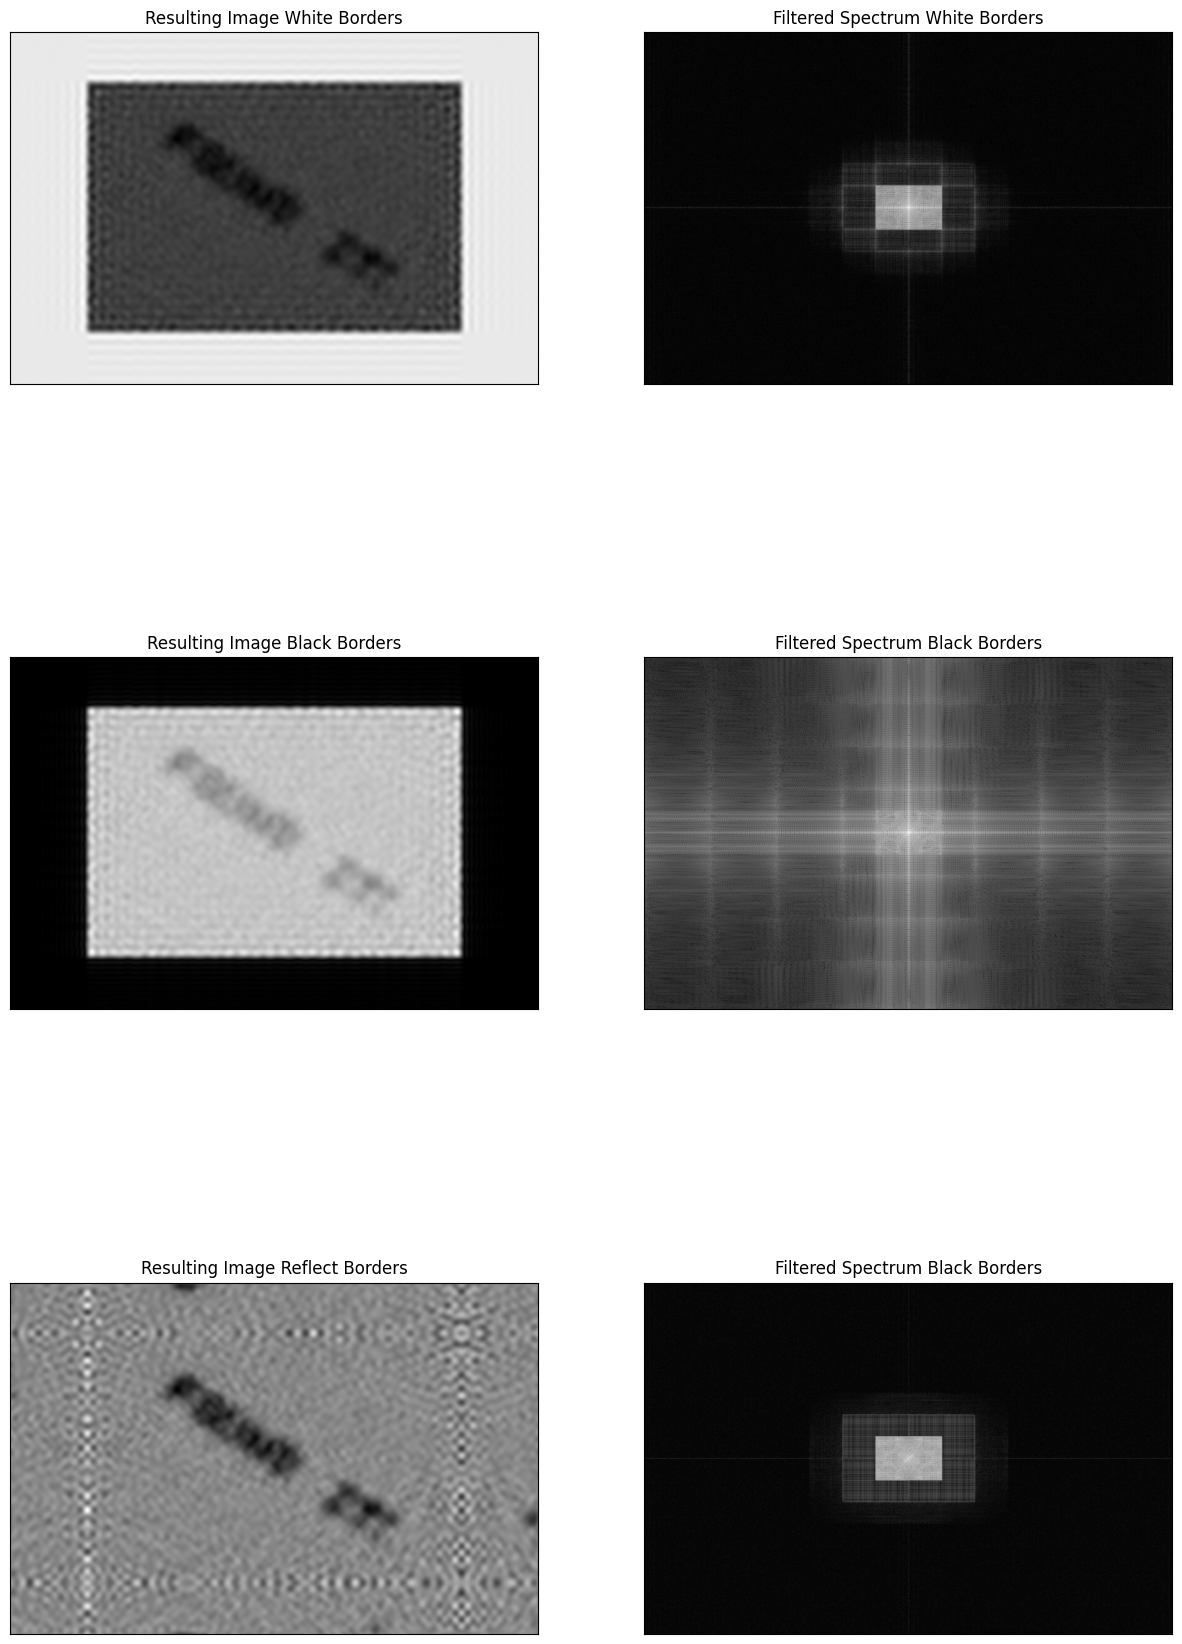

In [16]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(resized_img_back_w, cmap = 'gray')
plt.title('Resulting Image White Borders'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(filtered_spectrum_w, cmap = 'gray')
plt.title('Filtered Spectrum White Borders'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(resized_img_back_b, cmap = 'gray')
plt.title('Resulting Image Black Borders'), plt.xticks([]), plt.yticks([])
plt.subplot(324),plt.imshow(filtered_spectrum_b, cmap = 'gray')
plt.title('Filtered Spectrum Black Borders'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(resized_img_back_reflect, cmap = 'gray')
plt.title('Resulting Image Reflect Borders'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum_reflect, cmap = 'gray')
plt.title('Filtered Spectrum Black Borders'), plt.xticks([]), plt.yticks([])
plt.show()

### ILPF results

The borders that yielded the best results were the reflective (mirrored) borders.
This approach slightly reduced the banding effect.

On the other hand, using white or black borders caused significant changes in the image, which became visible in the frequency spectrum, leading to undesirable artifacts.

However, even with reflective borders, some loss of information was observed.

Given these observations, the image processing will proceed without applying the ILPF.

In [17]:
rows, cols = img_notch.shape
crow, ccol = rows // 2, cols // 2

# Radius of the inner and outer circles (center has no effect)
inner_radius = 10
outer_radius = 25

mask_2d = np.ones((rows, cols), dtype=np.float32)

# Create a 2D matrix with the distances from the center
y, x = np.ogrid[:rows, :cols]
dist_matrix = np.sqrt((y - crow)**2 + (x - ccol)**2)

# Factor to enhance the frequencies
factor = 1.75
decrease_factor = 0

# Apply the mask to the 2D matrix
mask_2d[(dist_matrix >= inner_radius) & (dist_matrix <= outer_radius)] = factor
mask_2d[dist_matrix > outer_radius] = decrease_factor

mask_3d = np.stack((mask_2d, mask_2d), axis=-1)


# compute the DFT
dft = cv2.dft(img_notch, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude
filtered_spectrum = 20*np.log(filtered_spectrum+0.0001)


# Apply the mask to the DFT
dft_proc_shift_enhanced = dft_proc_shift * mask_3d
# Compute the inverse DFT
dft_ishift = np.fft.ifftshift(dft_proc_shift_enhanced)

# Compute the complex values
img_enhanced_complex = cv2.idft(dft_ishift)

# Compute the magnitude of the complex values
img_enhanced = cv2.magnitude(img_enhanced_complex[:,:,0],
                                    img_enhanced_complex[:,:,1])

# Normalize to [0,1]
cv2.normalize(img_enhanced, img_enhanced, 0, 1, cv2.NORM_MINMAX)


dft_proc_enhanced = cv2.dft(img_enhanced, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift_enhanced = np.fft.fftshift(dft_proc_enhanced)

# Compute the magnitude spectrum
filtered_spectrum_enhanced = cv2.magnitude(dft_proc_shift_enhanced[:,:,0],
                                                    dft_proc_shift_enhanced[:,:,1])
filtered_spectrum_enhanced = 20 * np.log(filtered_spectrum_enhanced + 0.0001)

In [18]:
mask_spectrum = np.sqrt(np.power(mask_3d[:,:,0],2)+np.power(mask_3d[:,:,1],2))
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

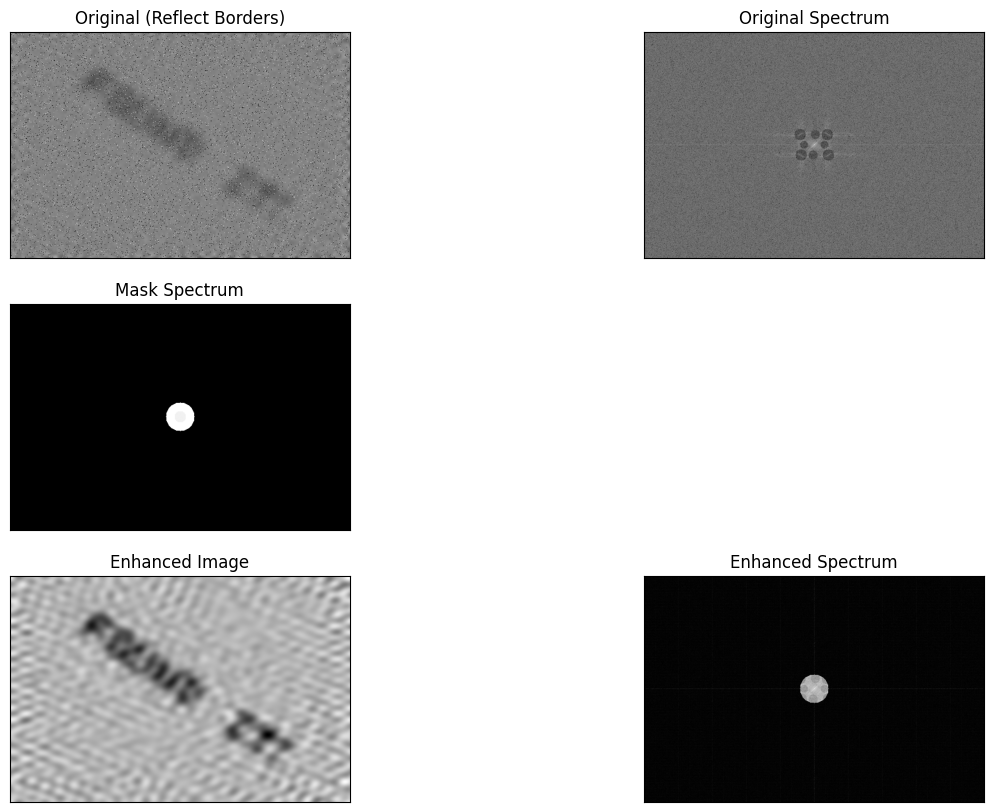

In [19]:
plt.figure(figsize=(15,10))
plt.subplot(321), plt.imshow(img_notch, cmap='gray')
plt.title('Original (Reflect Borders)'), plt.xticks([]), plt.yticks([])
plt.subplot(322), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Original Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323), plt.imshow(mask_spectrum, cmap='gray')
plt.title('Mask Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325), plt.imshow(img_enhanced, cmap='gray')
plt.title('Enhanced Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326), plt.imshow(filtered_spectrum_enhanced, cmap='gray')
plt.title('Enhanced Spectrum'), plt.xticks([]), plt.yticks([])

plt.show()

This filter introduced another unexpected result.
Testing with a factor of `0` revealed that it does not produce as much banding as the ILPF.

Ever the characters being blurred, they have more contrast, what makes it harder to decide if the results is better or worst.

For that reason, this filters will be tested until the end, delaying the comparation with the simple application of the notch filter.

The Ideal Low Pass Filter (ILPF) frequently results in substantial information loss and introduces undesirable artifacts such as banding due to its abrupt frequency cutoff characteristics. As an alternative approach, the Gaussian Filter presents a more effective solution. The Gaussian Filter's gradual frequency attenuation provides smoother transitions, thereby preserving more image information while minimizing artificial artifacts in the processed output.

In [20]:
#'''
def gaussian_filter(kernel_size, sigma=1, muu=0):

    # Initializing value of x,y as grid of kernel size
    # in the range of kernel size

    x, y = np.meshgrid(np.linspace(-1, 1, kernel_size),
                        np.linspace(-1, 1, kernel_size))
    dst2 = np.sqrt(x**2+y**2)

    # lower normal part of gaussian
    normal2 = 1/(2.0 * np.pi * sigma**2)

    # Calculating Gaussian filter
    gauss2 = np.exp(-((dst2-muu)**2 / (2.0 * sigma**2))) * normal2
    
    gauss2 = gauss2 / np.max(gauss2)
    
    return gauss2


# manually filter high frequencies using our own GLPF
kernel_size2 = 73
gaussF2 = gaussian_filter (kernel_size2)

# create a mask first, given by the Gaussian
GLPF_mask2 = np.zeros((rows, cols, 2))
frows = kernel_size2//2
fcols = kernel_size2//2
GLPF_mask2[crow-frows:crow+frows+1, ccol-fcols:ccol+fcols+1,0] = gaussF2
GLPF_mask2[crow-frows:crow+frows+1, ccol-fcols:ccol+fcols+1,1] = gaussF2


# apply mask and inverse DFT
dft_masked2 = dft_proc_shift*GLPF_mask2
# do not forget to undo the centering of the transform
dft_masked_ishift2 = np.fft.ifftshift(dft_masked2)
img_back2 = cv2.idft(dft_masked_ishift2)
# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back2 = cv2.magnitude(img_back2[:,:,0],img_back2[:,:,1])




dft_masked3 = dft_proc_shift_enhanced*GLPF_mask2
# do not forget to undo the centering of the transform
dft_masked_ishift3 = np.fft.ifftshift(dft_masked3)
img_back3 = cv2.idft(dft_masked_ishift3)
img_back3 = cv2.magnitude(img_back3[:,:,0],img_back3[:,:,1])
#'''

In [21]:
#'''
# compute the frequency spectrum of the MASKED_DFT, 
# just for display purposes
# module of the complex value
dft_proc_2 = cv2.dft(img_back2, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift_2 = np.fft.fftshift(dft_proc_2)
filtered_spectrum2 = cv2.magnitude(dft_proc_shift_2[:,:,0],dft_proc_shift_2[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum2 = 20*np.log(filtered_spectrum2+0.0001)
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum2 = np.sqrt(np.power(GLPF_mask2[:,:,0],2)+np.power(GLPF_mask2[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum2 = 20*np.log(mask_spectrum2+0.0001)





dft_proc_3 = cv2.dft(img_back3, flags = cv2.DFT_COMPLEX_OUTPUT)
dft_proc_shift_3 = np.fft.fftshift(dft_proc_3)

filtered_spectrum3 = cv2.magnitude(dft_proc_shift_3[:,:,0],dft_proc_shift_3[:,:,1])
filtered_spectrum3 = 20*np.log(filtered_spectrum3+0.0001)
mask_spectrum3 = np.sqrt(np.power(GLPF_mask2[:,:,0],2)+np.power(GLPF_mask2[:,:,1],2))
mask_spectrum3 = 20*np.log(mask_spectrum3+0.0001)
#'''

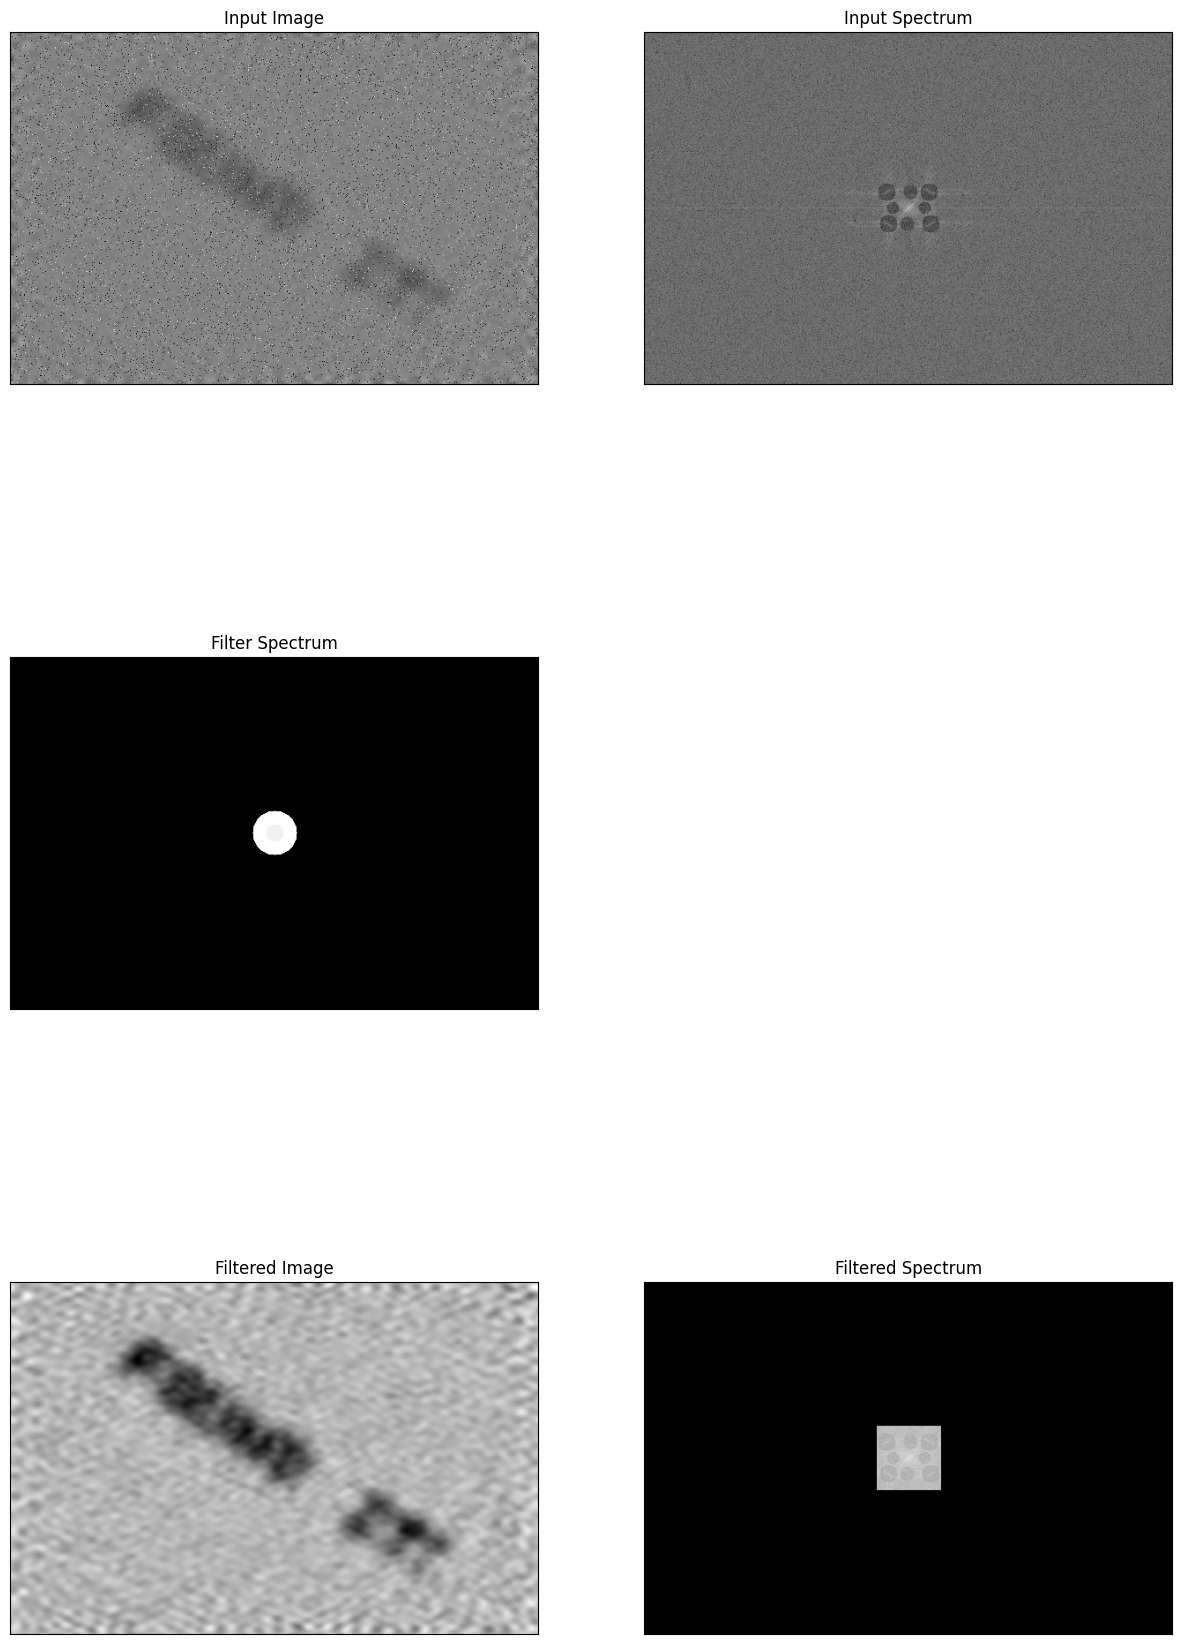

In [22]:
#'''
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img_notch, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back2, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum2, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()        
#'''

A comparative analysis between images processed with and without the Gaussian Filter does not provide optimal differentiation. A more effective evaluation is when we compare both on the final stage of the project, where the application of Canny edge detection algorithms would highlight the differences more distinctly.

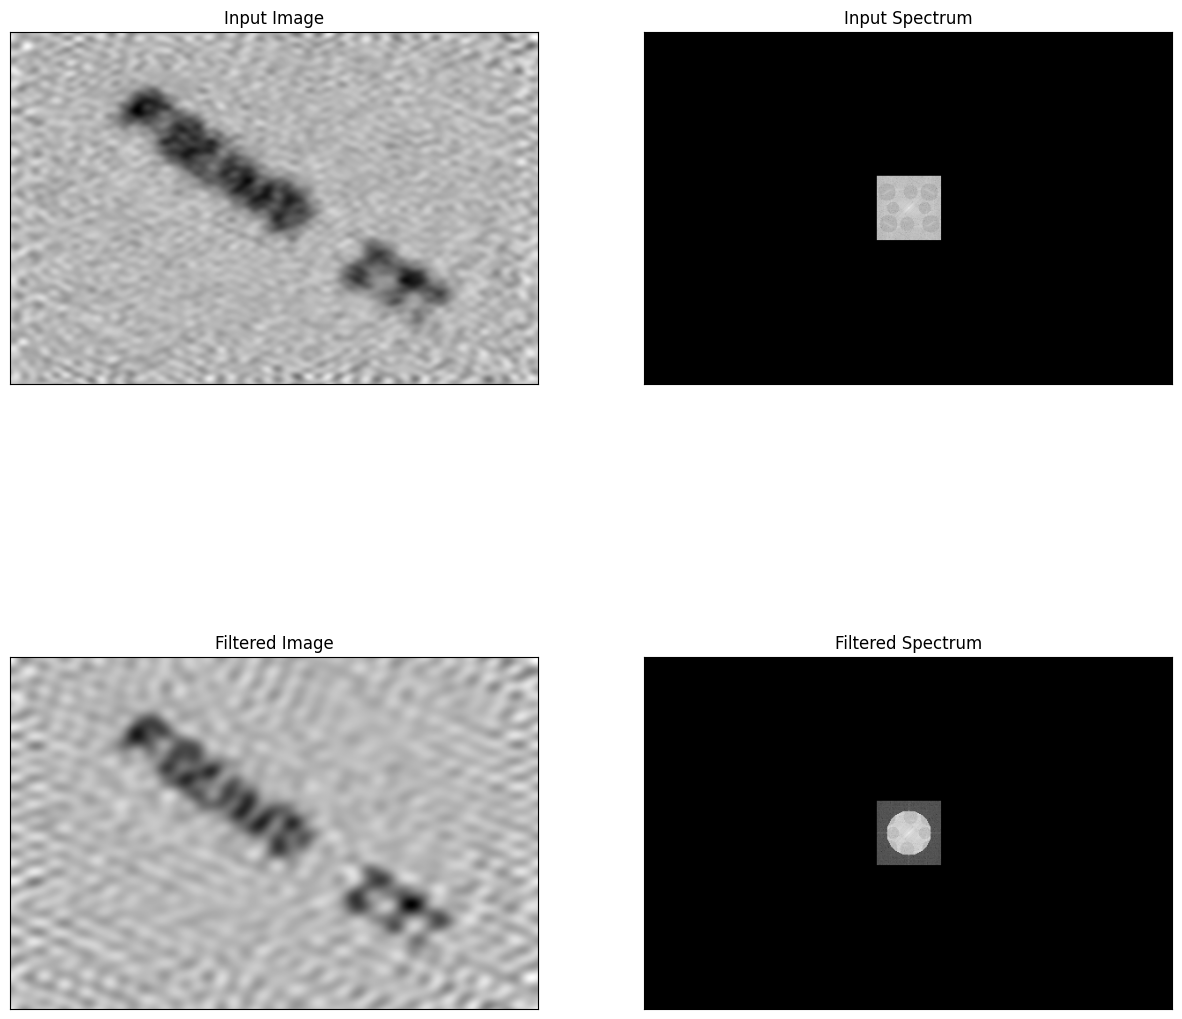

In [23]:
#'''
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img_back2, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(filtered_spectrum2, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(img_back3, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(324),plt.imshow(filtered_spectrum3, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()        
#'''

The image processed with both enhancement techniques and Gaussian filtering exhibits superior clarity. 

Both processing approaches will be subjected to continued testing throughout the remainder of the analytical procedure. This extended comparative assessment will facilitate the development of a more thorough and objective perspective regarding the visual efficacy of each method.

(Text(0.5, 1.0, 'Filtered Image Notch'), ([], []), ([], []))

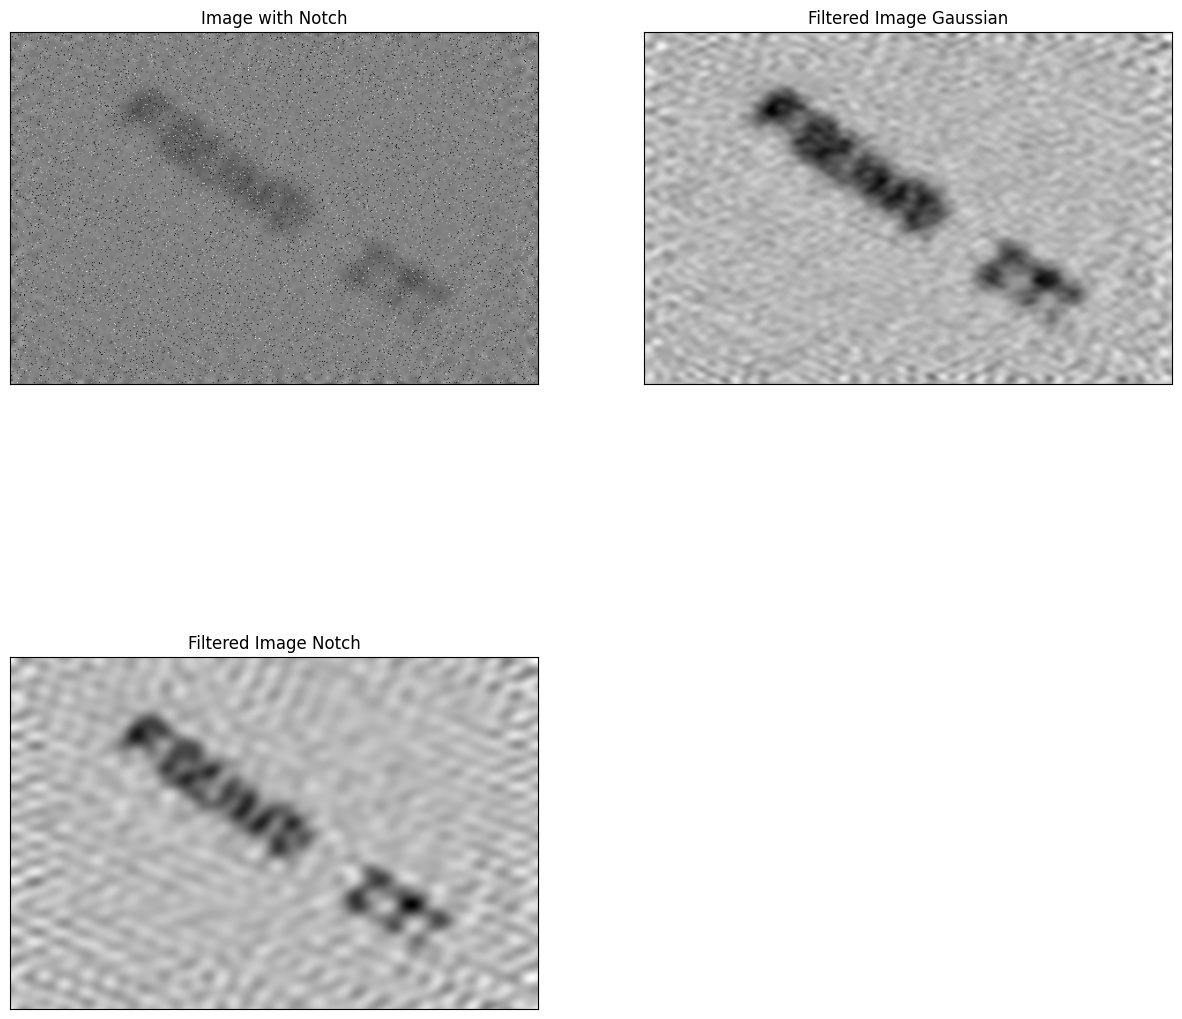

In [24]:
#'''
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img_notch, cmap = 'gray')
plt.title('Image with Notch'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(img_back2, cmap = 'gray')
plt.title('Filtered Image Gaussian'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(img_back3, cmap = 'gray')
plt.title('Filtered Image Notch'), plt.xticks([]), plt.yticks([])
#'''

Initialy, the image processed with the Gaussian filter demonstrates marginally superior noise reduction properties. However, this improvement comes at the expense of edge definition, which appears less pronounced compared to the unfiltered image. A comprehensive evaluation will be conducted at the final stage of analysis, where we will systematically enumerate and assess the advantages and disadvantages of applying the Gaussian filter to this specific image, supported by quantitative and qualitative arguments.

> **NOTES:**
>
> - Some of the tested filters that lead to worst results were kept in comments
>
> - The chosen values are determined using a trial-and-error approach to optimize the results.

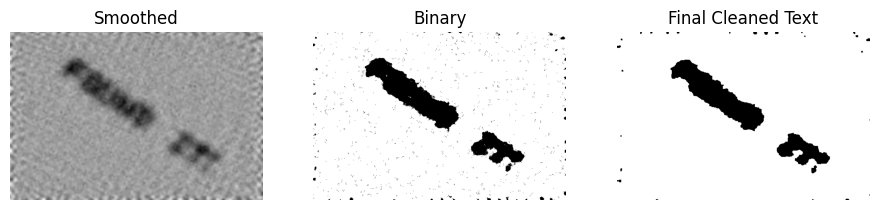

In [25]:
rescaled_img = rescale(img_notch)
rescaled_img_enhanced = rescale(img_enhanced)
rescaled_img_back2 = rescale(img_back2)
rescaled_img_back3 = rescale(img_back3)

# Apply CLAHE to enhance contrast (before smoothing!)
# clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
# img_contrast = clahe.apply(rescaled_img)

# Apply Unsharp Masking (sharpens edges before thresholding)
# gaussian_blur = cv2.GaussianBlur(rescaled_img, (5, 5), 1.5)
# sharpened = cv2.addWeighted(rescaled_img, 2.0, gaussian_blur, -1.0, 0)

# Apply Bilateral Filtering (softens noise, preserves edges)
smoothed = cv2.bilateralFilter(rescaled_img, d=9, sigmaColor=100, sigmaSpace=100)

smoothed_enhanced = cv2.bilateralFilter(rescaled_img_enhanced, d=9, sigmaColor=100, sigmaSpace=100)

smoothed_back2 = cv2.bilateralFilter(rescaled_img_back2, d=9, sigmaColor=100, sigmaSpace=100)

smoothed_back3 = cv2.bilateralFilter(rescaled_img_back3, d=9, sigmaColor=100, sigmaSpace=100)

# Apply Gamma Correction (increase contrast)
gamma = 1.5  # Reduced gamma for better balance
img_gamma = np.power(smoothed / 255.0, gamma) * 255
img_gamma = img_gamma.astype(np.uint8)

img_gamma_enhanced = np.power(smoothed_enhanced / 255.0, gamma) * 255
img_gamma_enhanced = img_gamma_enhanced.astype(np.uint8)

img_gamma_back2 = np.power(smoothed_back2 / 255.0, gamma) * 255
img_gamma_back2 = img_gamma_back2.astype(np.uint8)

img_gamma_back3 = np.power(smoothed_back3 / 255.0, gamma) * 255
img_gamma_back3 = img_gamma_back3.astype(np.uint8)

# Apply Otsu's Thresholding
_, binary = cv2.threshold(img_gamma, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

_, binary_enhanced = cv2.threshold(img_gamma_enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

_, binary_back2 = cv2.threshold(img_gamma_back2, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

_, binary_back3 = cv2.threshold(img_gamma_back3, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Use Morphological Operations (removes noise, strengthens edges)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary_cleaned = cv2.morphologyEx(binary_cleaned, cv2.MORPH_OPEN, kernel, iterations=2)

binary_cleaned_enhanced = cv2.morphologyEx(binary_enhanced, cv2.MORPH_CLOSE, kernel, iterations=2)
binary_cleaned_enhanced = cv2.morphologyEx(binary_cleaned_enhanced, cv2.MORPH_OPEN, kernel, iterations=2)

binary_cleaned_back2 = cv2.morphologyEx(binary_back2, cv2.MORPH_CLOSE, kernel, iterations=2)
binary_cleaned_back2 = cv2.morphologyEx(binary_cleaned_back2, cv2.MORPH_OPEN, kernel, iterations=2)

binary_cleaned_back3 = cv2.morphologyEx(binary_back3, cv2.MORPH_CLOSE, kernel, iterations=2)
binary_cleaned_back3 = cv2.morphologyEx(binary_cleaned_back3, cv2.MORPH_OPEN, kernel, iterations=2)

plt.figure(figsize=(15, 15))

plt.subplot(2, 4, 1)
plt.imshow(smoothed, cmap='gray')
plt.title("Smoothed")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(binary, cmap='gray')
plt.title("Binary")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(binary_cleaned, cmap='gray')
plt.title("Final Cleaned Text")
plt.axis('off')

plt.show()

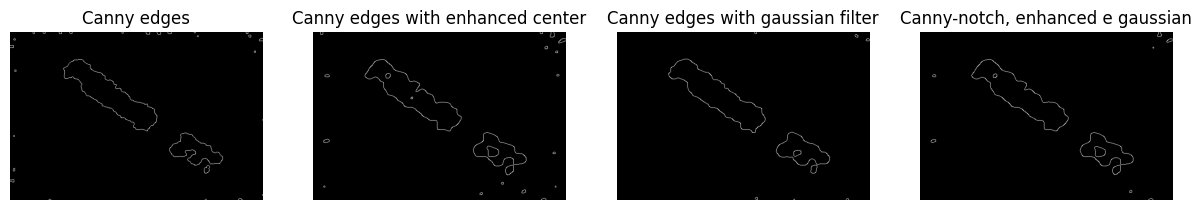

In [26]:
img_8bit = rescale(binary_cleaned)
# Apply Canny edge detector
edges = cv2.Canny(img_8bit, 100, 200)

img_8bit_enhanced = rescale(binary_cleaned_enhanced)
# Apply Canny edge detector
edges_enhanced = cv2.Canny(img_8bit_enhanced, 100, 200)

img_8bit_gaussian = rescale(binary_cleaned_back2)
# Apply Canny edge detector
edges_back2 = cv2.Canny(img_8bit_gaussian, 100, 200)

img_8bit_enhanced_gaussian = rescale(binary_cleaned_back3)
# Apply Canny edge detector
edges_back3 = cv2.Canny(img_8bit_enhanced_gaussian, 100, 200)

plt.figure(figsize=(15, 5))

plt.subplot(2, 4, 1)
plt.imshow(edges, cmap='gray')
plt.title("Canny edges")
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(edges_enhanced, cmap='gray')
plt.title("Canny edges with enhanced center")
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(edges_back2, cmap='gray')
plt.title("Canny edges with gaussian filter")
plt.axis('off')

plt.subplot(2, 4, 4)
plt.imshow(edges_back3, cmap='gray')
plt.title("Canny-notch, enhanced e gaussian")
plt.axis('off')

plt.show()

The application of the circular filter proved useful in enhancing details in the word `FOUND`. However, it resulted in a significant loss of information in the word `IT!`, due to its lighter appearance.

Given the objective of the treatment, the circular filter is not a viable option.

It is evident that the implementation with the Gaussian filter demonstrates inferior performance compared to alternative methods. 

The Gaussian filtering process has compromised the intercharacter spacing, resulting in diminished legibility of the text. When contrasted with the Canny edge detection applied after only notch filtering, some undeveloped aspects become apparent: 
- the exclamation mark exhibits degraded edge definition;
- the word `FOUND` processed with Gaussian filtering shows reduced edge clarity. This degradation occurs because the Gaussian filter's smoothing effect has caused a combination between noise and the letters boundaries.

> **NOTE:** Canny edges were considered due to better results after testing.

# Conclusion

This assignment has proven to be extremely valuable in gaining hands-on experience with handling and processing noisy images.

Although the final result is not perfect, we believe we made significant improvements to the input image, reducing noise and detecting the edges.

Despite the challenges, the outcome demonstrates substantial progress, and we consider it a meaningful achievement in terms of image processing.